In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
import itertools
from collections import Counter
import nltk
import datetime

import string
from nltk import wordpunct_tokenize



import re

#progress bar
from tqdm import tqdm, tqdm_notebook

# instantiate
tqdm.pandas(tqdm_notebook)

In [ ]:
dataReviewsChunk = pd.read_json('../data/reviews.json', lines=True, chunksize=10000)

In [ ]:

chunk_list = []  # append each chunk df here 

# Each chunk is in df format
for chunk in dataReviewsChunk:

    chunk_list.append(chunk)


In [ ]:
dataReviews = pd.concat(chunk_list)

### Exploratory Data Analysis

In [ ]:
print("Number of reviews not filtered:", len(dataReviews))

In [ ]:
def convert_int_value(int_value):
    return int_value["$numberInt"]

#### Reducing reviews

In [ ]:
dataReviews["rating"]=dataReviews["rating"].apply(convert_int_value).astype(int)

In [ ]:
dataReviews["helpful"]=dataReviews["helpful"].apply(convert_int_value).astype(int)

In [ ]:
dataReviews = dataReviews[dataReviews.helpful != 0]

In [ ]:
dataReviews = dataReviews[dataReviews.verified == True]

In [ ]:
counts = dataReviews["rating"].value_counts()

In [ ]:
print("Reduced reviews distribution [5-1] stars:", counts.values)

In [ ]:
x = counts._index
print(x)
y = counts.values
print(y)

In [ ]:
fig = plt.figure(figsize=(18,6))
sns.barplot(x=counts._index, y=counts.values)
plt.title("Rating distribution")
plt.show()

In [ ]:
print("Proportion of review with score=1: {}%".format(len(dataReviews[dataReviews.rating == 1]) / len(dataReviews)*100))
print("Proportion of review with score=2: {}%".format(len(dataReviews[dataReviews.rating == 2]) / len(dataReviews)*100))
print("Proportion of review with score=3: {}%".format(len(dataReviews[dataReviews.rating == 3]) / len(dataReviews)*100))
print("Proportion of review with score=4: {}%".format(len(dataReviews[dataReviews.rating == 4]) / len(dataReviews)*100))
print("Proportion of review with score=5: {}%".format(len(dataReviews[dataReviews.rating == 5]) / len(dataReviews)*100))

### Preparing dataset for sentiment analysis

In [24]:
dataReviews = pd.read_csv('../data/dati_ridotti.csv', sep=',')

In [25]:
dataReviews_POS = pd.DataFrame(dataReviews[dataReviews.rating > 3].sample(1000))
dataReviews_POS['target'] = 'POS'
dataReviews_POS['polarity'] = 'None'


In [26]:
dataReviews_NEG = pd.DataFrame(dataReviews[dataReviews.rating < 3].sample(1000))
dataReviews_NEG['target'] = 'NEG'
dataReviews_NEG['polarity'] = 'None'

In [27]:
dataReviews_NEUT = pd.DataFrame(dataReviews[dataReviews.rating == 3].sample(1000))
dataReviews_NEUT['target'] = 'NEUT'
dataReviews_NEUT['polarity'] = 'None'

In [28]:
# export csv to do sentix in R
dataReviews_POS.to_csv('../data/dataReviews_POS.csv', index=False, sep=',')
dataReviews_NEG.to_csv('../data/dataReviews_NEG.csv', index=False, sep=',')
dataReviews_NEUT.to_csv('../data/dataReviews_NEUT.csv', index=False, sep=',')

### Execute SentimentR.R

In [ ]:
# EXECUTE R CODE

### Read reviews polarized

In [55]:
# import csv after sentix in R
dataReviews_POS = pd.read_csv('../data/dataReviews_POS_pol.csv', sep=',').mask(dataReviews_POS.eq('None')).dropna()
dataReviews_NEG = pd.read_csv('../data/dataReviews_NEG_pol.csv', sep=',').mask(dataReviews_NEG.eq('None')).dropna()
dataReviews_NEUT = pd.read_csv('../data/dataReviews_NEUT_pol.csv', sep=',').mask(dataReviews_NEUT.eq('None')).dropna()

In [56]:
# merging dataframes
dataReviews_pol = pd.concat([dataReviews_POS,dataReviews_NEG,dataReviews_NEUT], ignore_index=True)
# dataReviews_pol = pd.concat([dataReviews_POS,dataReviews_NEG], ignore_index=True)

In [57]:
len(dataReviews_pol)

2994

### Accuracy for each target

In [58]:
print("% accuracy POS: ", len(dataReviews_POS.loc[dataReviews_POS.polarity.astype(float) > 0])/len(dataReviews_POS)*100)

% accuracy POS:  93.17953861584755


In [60]:
print("% accuracy NEG: ", len(dataReviews_POS.loc[dataReviews_NEG.polarity.astype(float) < 0])/len(dataReviews_NEG)*100)

% accuracy NEG:  27.9839518555667


In [61]:
print("% 3 stars with positive polarities: ", len(dataReviews_NEUT.loc[dataReviews_NEUT.polarity.astype(float) > 0])/len(dataReviews_NEUT)*100)

% 3 stars with positive polarities:  82.6


### Compare distribution of polarity and ratings

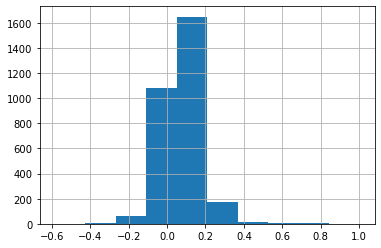

In [64]:
dataReviews_pol['polarity'].astype(float).hist()

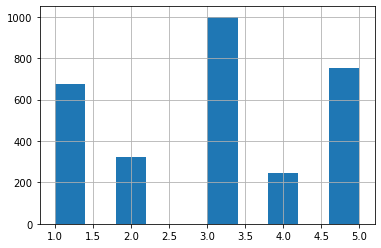

In [63]:
dataReviews_pol['rating'].hist()

### Sentix (DISCARD ALL FROM HERE TO THE END ?)

In [ ]:
from nltk.stem.snowball import SnowballStemmer

In [ ]:
stemmer = SnowballStemmer("italian")
def stemming_token(sentence,stemmer):
    stem = []
    for elem in sentence:
        stem.append(stemmer.stem(elem))
    return stem

In [ ]:
sentix = pd.read_csv("../data/sentix.csv", sep="\t", header=None)
sentix.columns=["lemma", "POS", "synset_ID", "score_1", "score_2", "polarity", "intensity"] 
sentix.head(1)

In [ ]:
sentix["lemma"] = sentix["lemma"].astype(str)
sentix["stemming"] = sentix["lemma"].apply(stemmer.stem)
sentix.head(5)

In [ ]:
sentix["polarity"] = sentix["polarity"]*5
sentix.head(1)


### Sentix for lexicon based sentiment analysis

In [ ]:
sentix_agg = sentix.loc[sentix["POS"]=="a"]

# add extra words
sentix_agg = sentix_agg.append({'stemming': stemmer.stem('reso'), 'polarity': -5, 'intensity': 1, 'synset_ID': '00048739'}, ignore_index = True)
sentix_agg = sentix_agg.append({'stemming': stemmer.stem('restituito'), 'polarity': -5, 'intensity': 1, 'synset_ID': '00048739'}, ignore_index = True)
sentix_agg = sentix_agg.append({'stemming': 'bel', 'polarity': 5, 'intensity': 1, 'synset_ID': '00217728'}, ignore_index = True)

In [ ]:
sentix = sentix.append({'stemming': stemmer.stem('reso'), 'polarity': -5, 'intensity': 1, 'synset_ID': '00048739'}, ignore_index = True)
sentix = sentix.append({'stemming': stemmer.stem('restituito'), 'polarity': -5, 'intensity': 1, 'synset_ID': '00048739'}, ignore_index = True)
sentix = sentix.append({'stemming': 'bel', 'polarity': 5, 'intensity': 1, 'synset_ID': '00217728'}, ignore_index = True)

In [ ]:
sentix_agg.iloc[len(sentix_agg)-1]

In [ ]:
dataReviews_POS["token"] = dataReviews_POS["body"].apply(word_tokenize)
dataReviews_POS["stemming"] = [stemming_token(row["token"], stemmer) for _, row in dataReviews_POS.iterrows()]
dataReviews_NEG["token"] = dataReviews_NEG["body"].apply(word_tokenize)
dataReviews_NEG["stemming"] = [stemming_token(row["token"], stemmer) for _, row in dataReviews_NEG.iterrows()]

In [ ]:
dataReviews_POS.head(1)

In [ ]:
dataReviews_NEG.head(1)

In [ ]:
import statistics 

def lexicon_based_score(sentence,df_sentix):
    sum_pol = 0
    count=0
    #print(sentence)
    context = None
    for elem in sentence:
        #polarity = df_sentix[df_sentix.stemming  == elem]['polarity']
        values = df_sentix[df_sentix.stemming  == elem][['polarity','intensity','synset_ID']]
        if not(values.empty):
            count += 1
            #print(elem)
            #print(polarity)
            #print(sum_pol)
            #if len(polarity >1):
                #print(type(polarity.iloc[0]))
                #print("polarity",polarity.value_counts())
            #sum_pol += polarity.value_counts().index[0]#statistics.mean(polarity)
            synset_values = values[values.synset_ID == context]           
            if synset_values.empty:
                synset_values = values.iloc[0]
                context = synset_values['synset_ID']
            else:
                synset_values =  synset_values.iloc[0]
            sum_pol += synset_values['polarity']*synset_values['intensity']
            
            #print(polarity)
            #print(statistics.mean(polarity))
            #else:
            #    sum_pol += polarity
    #print(sum_pol)
    #print("_________________________________________________________")
    if count != 0:
        return sum_pol/count
    return 0

In [ ]:
polarity = sentix[sentix.stemming  == stemmer.stem('subito')][['polarity','intensity','synset_ID']]
polarity.iloc[0]['polarity']*polarity.iloc[0]['intensity']

#### Sentix on positive reviews

In [ ]:
dataReviews_POS["pol"] = dataReviews_POS["stemming"].progress_apply(lambda x: lexicon_based_score(x,sentix_agg))


In [ ]:
dataReviews_NEG["pol"] = dataReviews_NEG["stemming"].progress_apply(lambda x: lexicon_based_score(x,sentix_agg))


In [ ]:
print("% accuracy POS: ", len(dataReviews_POS.loc[dataReviews_POS.pol > 0])/len(dataReviews_POS)*100)

In [ ]:
print("% accuracy NEG: ", len(dataReviews_NEG.loc[dataReviews_NEG.pol < 0])/len(dataReviews_NEG)*100)

In [ ]:
dataReviews_NEG[dataReviews_NEG.pol > 0]['body'].values[0]

In [ ]:
stemmer.stem('pessim')

### Prodotti nel tempo

In [ ]:
dataReviews["product"]

In [ ]:
prod = "B00DDPI5NS"
#prod = "B07DMJPV31"
df_product = dataReviews[dataReviews["product"]  == prod]
df_product

In [ ]:
#delete day
df_product=df_product.assign(
    Period=df_product.date.dt.to_period('M')
)
df_product

In [ ]:
df_product['token']=df_product['body'].progress_apply(word_tokenize)

In [ ]:
df_product

In [ ]:
sub_data

In [ ]:
sub_data["stemming"]=[stemming_token(row["token"], stemmer) for _, row in sub_data.iterrows()]
df_product["stemming"] = [stemming_token(df_product["token"], stemmer) for _, row in df_product.iterrows()]

In [ ]:
df_product['lexicon_score_sentix']= df_product["stemming"].progress_apply(lambda x: lexicon_based_score(x,sentix_agg))

In [ ]:
#dataReviews["product"]
df_month = df_product[['Period','rating']].groupby(['Period']).mean()
df_month

In [ ]:
df_month.plot(style='.-')

In [ ]:
df_product [df_product["Period"]  == "2019-03"]

In [ ]:
# manage_date(df_product["Period"].iloc[0])
df_product["new_period"] = df_product["Period"].apply(manage_date)
df_product

In [ ]:
final_product_df = df_product[['new_period','rating']].groupby(['new_period']).mean()
final_product_df

In [ ]:
final_product_df.plot(style='.-')